In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as mode
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Setting a figure size of all the graphs at first
plt.rcParams['figure.figsize'] = 12,8
plt.style.use('ggplot')

# Disabling warnings
import warnings
warnings.filterwarnings('ignore')

In [154]:
df_train = pd.read_csv('train_bigmart.csv')
df_test = pd.read_csv('test_bigmart.csv')
submission = pd.read_csv('sample_submission_8RXa3c6.csv')

In [155]:
print('Train set shape : ', df_train.shape)
print('Test set shape : ', df_test.shape)

Train set shape :  (8523, 12)
Test set shape :  (5681, 11)


In [89]:
df_train.head(4)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800


From the first look at the data, I assume the variables that will have higher impact on the Outlet sales are: 
``Item_Visibility`` , ``Item_Type`` , ``OutletSize`` , ``Outlet_Location_Type`` , ``Outlet_Type``.


The target variable is ``Item_Outlet_Sales`` .

## Exploratory Data Analysis

In [90]:
df_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### Few observations we can make from here are:

1. The very first outlet was established in year 1985 & the latest was in 2009

2. The item has atleat a weight of 4lbs with the maximum going up to 21lbs

3. Visibility of any time cannot '0' as we can see here, there would be some manipulation happening here in this column

4. The average sales of all the outlet is 2181 and the overall sales ranges from - 33 to 13086 dollars


In [91]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


There are total 7 categoical columns & few missing values which can be delt with a little later

In [92]:
t = df_train.groupby(['Outlet_Location_Type'])['Item_Outlet_Sales', 'Item_MRP'].mean()
t.style.background_gradient(cmap = 'BuPu')

,Item_Outlet_Sales,Item_MRP
Outlet_Location_Type,,
Tier 1,1876.91,140.87
Tier 2,2323.99,141.167
Tier 3,2279.63,140.935


In [93]:
ob = df_train.groupby('Outlet_Location_Type')

for name,group in ob:
    print(name, 'contains', group.shape[0], 'rows')

Tier 1 contains 2388 rows
Tier 2 contains 2785 rows
Tier 3 contains 3350 rows


In [94]:
ob.get_group('Tier 2').head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
19,FDU02,13.350,Low Fat,0.102492,Dairy,230.5352,OUT035,2004,Small,Tier 2,Supermarket Type1,2748.4224
22,NCB30,14.600,Low Fat,0.025698,Household,196.5084,OUT035,2004,Small,Tier 2,Supermarket Type1,1587.2672
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
26,FDV10,7.645,Regular,0.066693,Snack Foods,42.3112,OUT035,2004,Small,Tier 2,Supermarket Type1,1065.2800
33,FDO23,17.850,Low Fat,0.000000,Breads,93.1436,OUT045,2002,NaN,Tier 2,Supermarket Type1,2174.5028
46,NCP05,19.600,Low Fat,0.000000,Health and Hygiene,153.3024,OUT045,2002,NaN,Tier 2,Supermarket Type1,2428.8384
47,FDV49,10.000,Low Fat,0.025880,Canned,265.2226,OUT045,2002,NaN,Tier 2,Supermarket Type1,5815.0972
53,FDA43,10.895,Low Fat,0.065042,Fruits and Vegetables,196.3794,OUT017,2007,NaN,Tier 2,Supermarket Type1,3121.2704


Let's check the distribution of our target column - ``Item_Outlet_Sales``

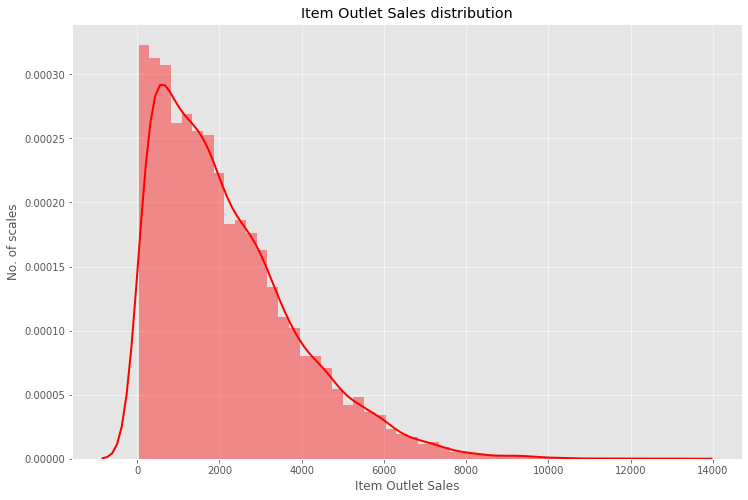

In [95]:
sns.distplot(df_train.Item_Outlet_Sales, bins=50, color = 'red')
plt.xlabel('Item Outlet Sales')
plt.ylabel('No. of scales')
plt.title('Item Outlet Sales distribution');

Our target column is ``left skewed``

Let's find out correlation between numerical features

In [96]:
num_feature = df_train.select_dtypes(include=[np.number])
num_feature.dtypes

Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
dtype: object

In [97]:
num_feature.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64


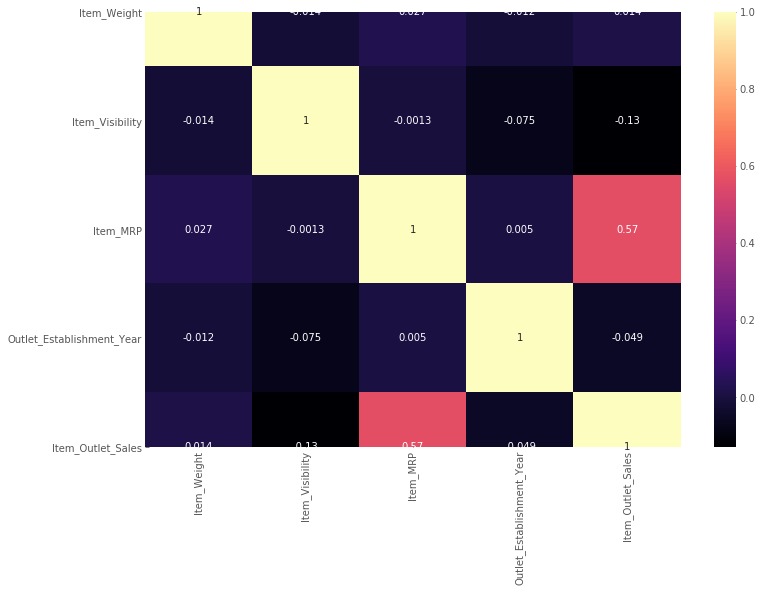

In [98]:
plt.style.use('bmh')
print(num_feature.corr()['Item_Outlet_Sales'].sort_values(ascending=False))
sns.heatmap(num_feature.corr(), annot=True, cmap = 'magma');

We can clearly see Mrp of any item is correlated with the sales of the outlet. 

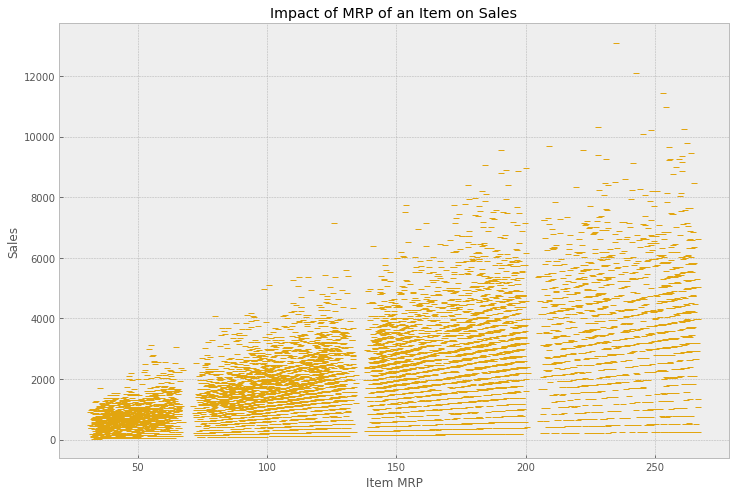

In [99]:
plt.plot(df_train['Item_MRP'], df_train['Item_Outlet_Sales'], '_', color = '#E2A50F')
plt.xlabel('Item MRP')
plt.ylabel('Sales')
plt.title('Impact of MRP of an Item on Sales');

### Ploting some of categorical variables.

Natural counterpart of histograms are frequency and bar charts for categorical variables

In [100]:
# Checking all categorical variables
cat_features = df_train.select_dtypes(include=[np.object])
cat_features.dtypes

Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object

``Item_Identifier`` is the unique id of a particular item in all the stores

In [101]:
print(df_train.Item_Identifier.value_counts().head(10))
print()
print('No. of Unique itmes : ', df_train.Item_Identifier.nunique())

FDW13    10
FDG33    10
FDP25     9
FDV60     9
FDX20     9
FDV38     9
FDF56     9
NCB18     9
FDX04     9
FDX31     9
Name: Item_Identifier, dtype: int64

No. of Unique itmes :  1559


There are total ``1559`` unique products present across all the stores

In [102]:
df_train.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

If we notice there is some repition in the data, boardly we can divide this in 2 categories i.e; ``Low Fat`` & ``Regular``. We can remove that in during feature engineering, right now we can manupulate it just to graphically represent it.

We shall plot each categorical variable and its impact on sales

In [103]:
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace('LF','Low Fat')
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace('low fat', 'Low Fat')
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace('reg', 'Regular')

### Fat Content & its impact on Sales

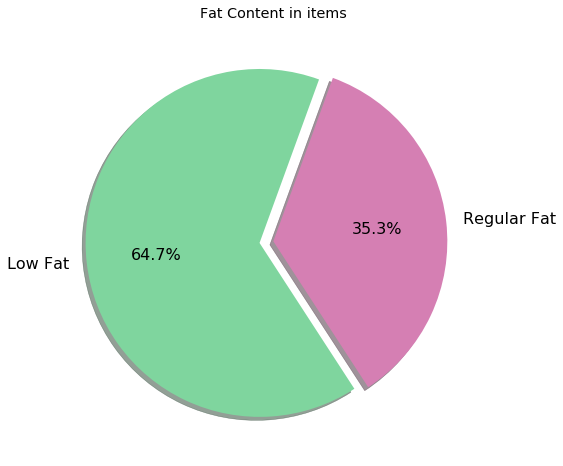

In [104]:
plt.style.use('bmh')
color = '#7FD59E', '#D57FB3'
plt.pie(df_train.Item_Fat_Content.value_counts(), data = df_train, labels = ('Low Fat', 'Regular Fat'), 
        colors = color, autopct='%1.1f%%', startangle = 70, shadow = True, explode = (0.08, 0), textprops={'fontsize': 16})
plt.title('Fat Content in items');

                  Item_Outlet_Sales
Item_Fat_Content                   
Low Fat                 2157.711534
Regular                 2224.561170


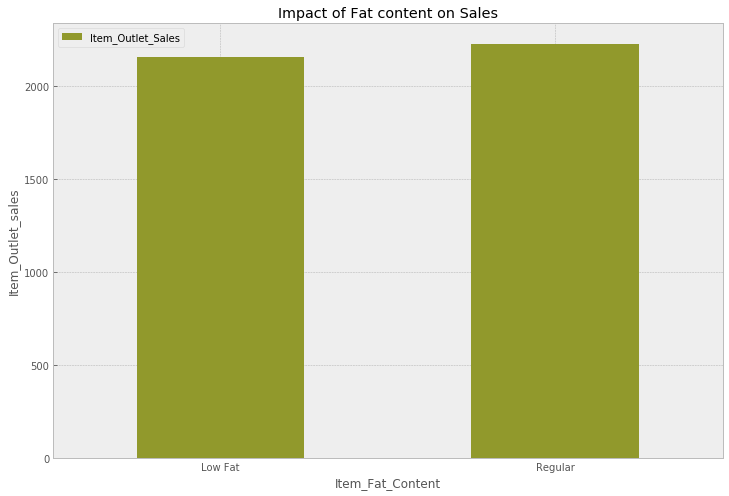

In [105]:
# Lets see if fat content has any impact on the sales
Fat_cont_pivot = df_train.pivot_table(index = 'Item_Fat_Content', values = 'Item_Outlet_Sales', aggfunc = np.mean)
print(Fat_cont_pivot)

Fat_cont_pivot.plot(kind = 'bar', color = '#91992C')
plt.xlabel('Item_Fat_Content')
plt.xticks(rotation = 0)
plt.ylabel('Item_Outlet_sales')
plt.title('Impact of Fat content on Sales');

The other categorical variable is ``Item_type``, lets check what are the different items sold in the outlet and does it have any impact on the sales.

### Item Type and its impact on Sales

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


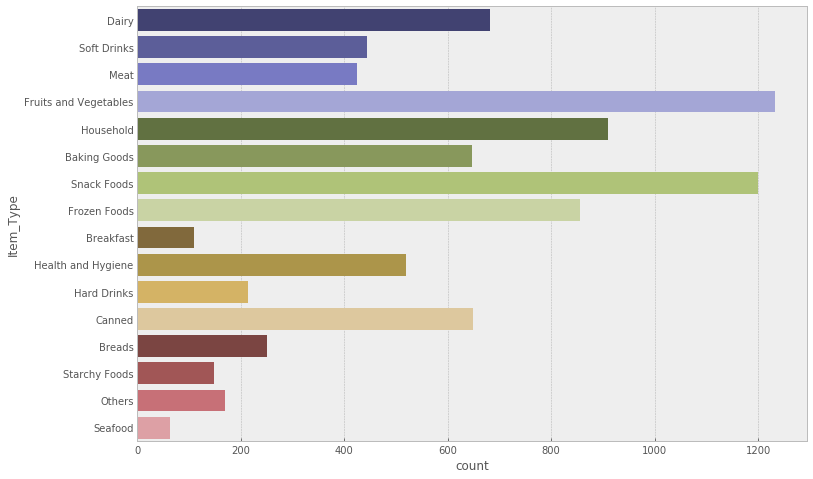

In [106]:
print(df_train['Item_Type'].value_counts())
sns.countplot(y=df_train['Item_Type'], palette = 'tab20b');

                       Item_Outlet_Sales
Item_Type                               
Baking Goods                 1952.971207
Breads                       2204.132226
Breakfast                    2111.808651
Canned                       2225.194904
Dairy                        2232.542597
Frozen Foods                 2132.867744
Fruits and Vegetables        2289.009592
Hard Drinks                  2139.221622
Health and Hygiene           2010.000265
Household                    2258.784300
Meat                         2158.977911
Others                       1926.139702
Seafood                      2326.065928
Snack Foods                  2277.321739
Soft Drinks                  2006.511735
Starchy Foods                2374.332773


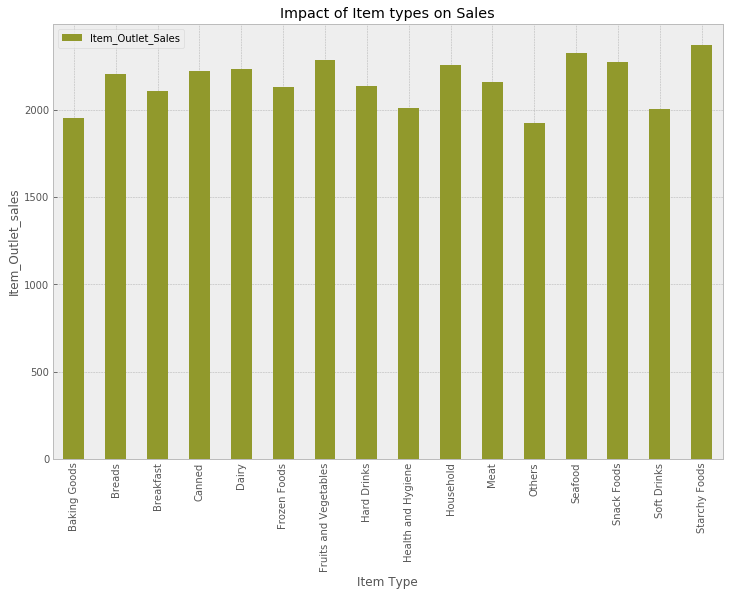

In [107]:
Item_type_pivot = df_train.pivot_table(index = 'Item_Type', values = 'Item_Outlet_Sales', aggfunc = np.mean)
print(Item_type_pivot)

Item_type_pivot.plot(kind = 'bar', color = '#91992C')
plt.xlabel('Item Type')
plt.xticks(rotation = 90)
plt.ylabel('Item_Outlet_sales')
plt.title('Impact of Item types on Sales');

### Outlet Size & its impact on Sales

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


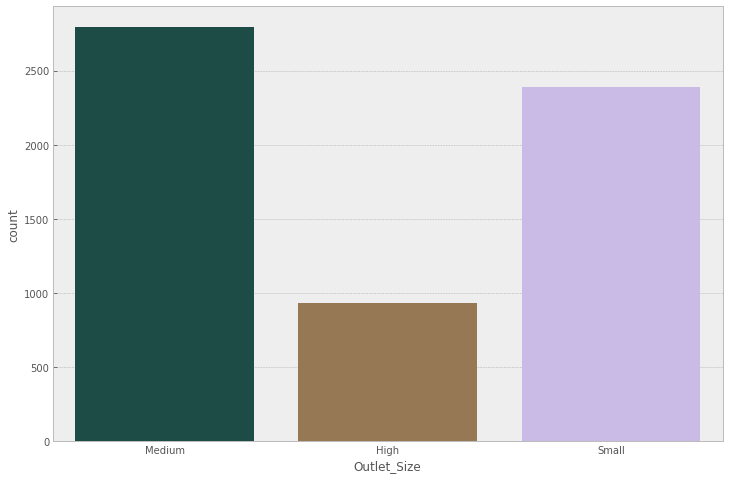

In [108]:
print(df_train['Outlet_Size'].value_counts())
sns.countplot(x=df_train['Outlet_Size'], palette = 'cubehelix');

#### We see, medium outlet are more in number when compared to two. Infact, big outlets are very less when compared to the other two

             Item_Outlet_Sales
Outlet_Size                   
High               2298.995256
Medium             2681.603542
Small              1912.149161


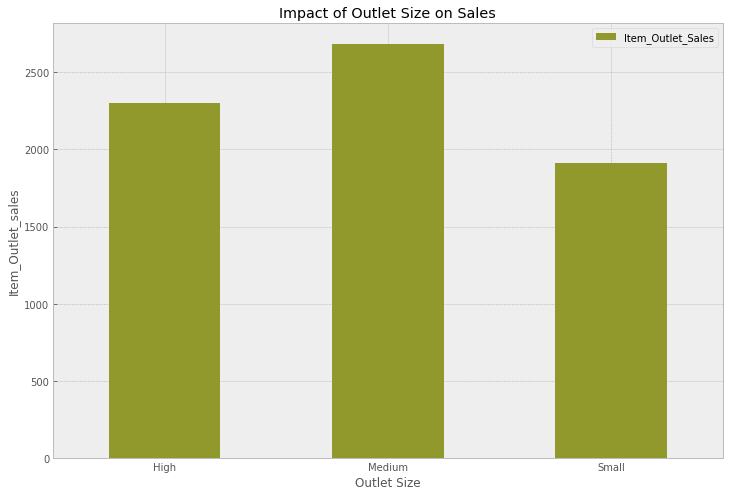

In [109]:
out_size_pivot = df_train.pivot_table(index = 'Outlet_Size', values = 'Item_Outlet_Sales', aggfunc = np.mean)
print(out_size_pivot)

out_size_pivot.plot(kind = 'bar', color = '#91992C')
plt.xlabel('Outlet Size')
plt.xticks(rotation = 0)
plt.ylabel('Item_Outlet_sales')
plt.title('Impact of Outlet Size on Sales');

The sales in smaller outlets is very low though they were more in number compared to higher outlets and there is very minimal difference between the sales higher size of outlets and medium sized outlets, though the number of large outlets are less in number.

### Oulet Location Type and its impact on Sales

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


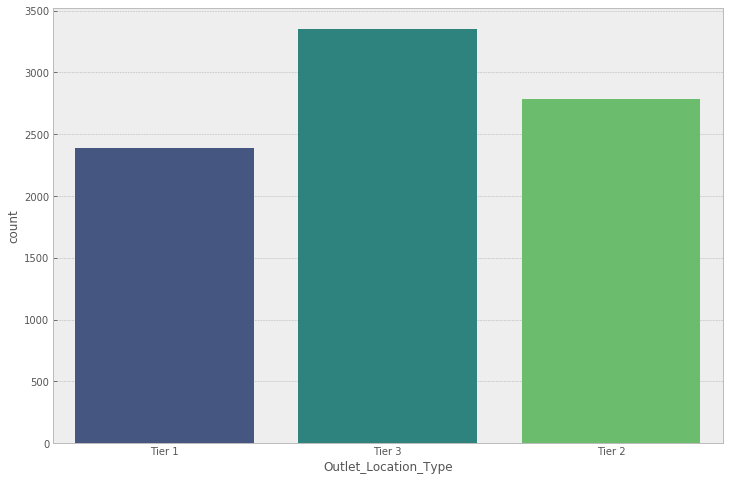

In [110]:
print(df_train['Outlet_Location_Type'].value_counts())
sns.countplot(x=df_train['Outlet_Location_Type'], palette = 'viridis');

Cities that are just beginning to wake up have more number of outlets compared to the other developed cities. Let's see if sales are impacted byt the Location

                      Item_Outlet_Sales
Outlet_Location_Type                   
Tier 1                      1876.909159
Tier 2                      2323.990559
Tier 3                      2279.627651


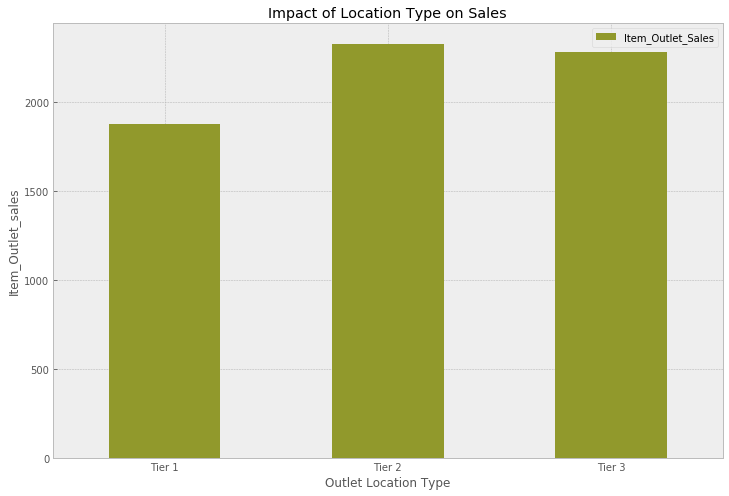

In [111]:
out_loc_pivot = df_train.pivot_table(index = 'Outlet_Location_Type', values = 'Item_Outlet_Sales', aggfunc = np.mean)
print(out_loc_pivot)

out_loc_pivot.plot(kind = 'bar', color = '#91992C')
plt.xlabel('Outlet Location Type')
plt.xticks(rotation = 0)
plt.ylabel('Item_Outlet_sales')
plt.title('Impact of Location Type on Sales');

### Outlet Type and its impact on Sales

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64


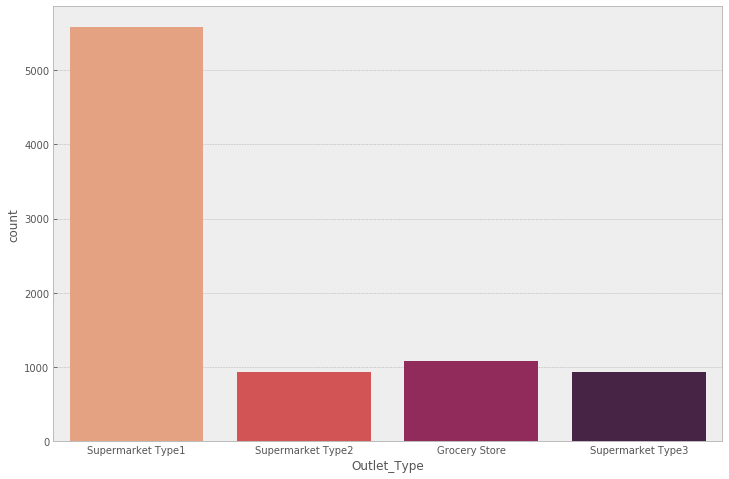

In [112]:
print(df_train['Outlet_Type'].value_counts())
sns.countplot(x=df_train['Outlet_Type'], palette = 'rocket_r');

Type 1 Supermarket is a lot more in number compared to the other supermarkets or grocery store, lets see if that impacts the sale

                   Item_Outlet_Sales
Outlet_Type                         
Grocery Store             339.828500
Supermarket Type1        2316.181148
Supermarket Type2        1995.498739
Supermarket Type3        3694.038558


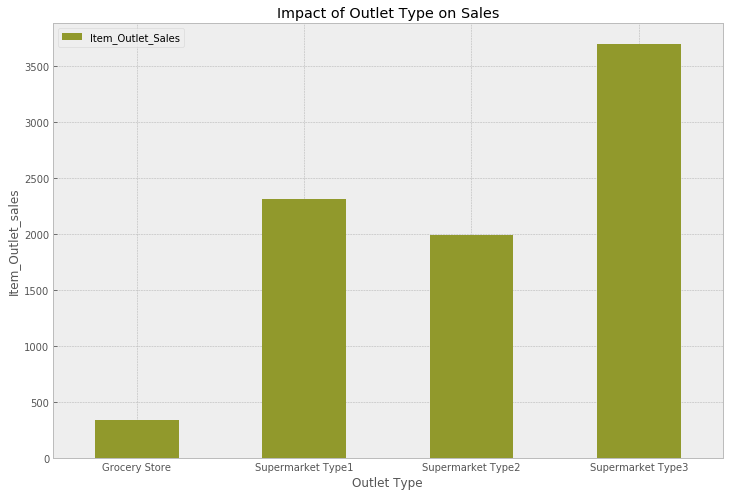

In [113]:
out_type_pivot = df_train.pivot_table(index = 'Outlet_Type', values = 'Item_Outlet_Sales', aggfunc = np.mean)
print(out_type_pivot)

out_type_pivot.plot(kind = 'bar', color = '#91992C')
plt.xlabel('Outlet Type')
plt.xticks(rotation = 0)
plt.ylabel('Item_Outlet_sales')
plt.title('Impact of Outlet Type on Sales');

There are quite a good number of ``grocery stores`` but sale happening there is very minimal. Also, ``Type 1 Supermarket`` is higher in number but it is not performing well it seems. The highest sales is happening is ``Type 3 Supermarket`` despite of, there are not many outlets of it.

## Data Pre-processing

After performing EDA, we are finally able to make some conclusions:

1. The variables which we thought have higher impact on the outlet sales amongst that ``Item_Visibilty`` and ``Item_Type`` seem to have no high positive correlation with the sales, were as the Outlet's Size, Location & Type have high impact on the sales.


2. While looking at the ``Item_Identifier`` variable, we observed there are some letters present in the id as FD, DR, NC, which we can assume to be as Food, Drinks & Non-Consumable. Perfect, we can extract a new variable from it.


3. As we saw earlier variable ``Item_Visiblity`` has some values as ZERO, which does not make any sense, as this just means that the item is not present in the store.


4. From ``Outlet_Establishment_Year`` we saw its values vary from 1985 to 2009, we can create a varibale indicating how old the outlet is.


5. We saw that there are missing values in ``Item_Weight`` and ``Outlet_Size`` variable.


Let's check if there are null values & we can impute all the null values 

In [114]:
df_train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [115]:
df_test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [116]:
# We can simply impute the missing values of Item weight by its mean.
df_train['Item_Weight'].fillna(df_train['Item_Weight'].mean(), inplace=True)
df_test['Item_Weight'].fillna(df_test['Item_Weight'].mean(), inplace=True)

In [117]:
# Determing the mode for each -Train Data
out_size_mode_train = df_train.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = lambda x: x.mode())

In [118]:
def nan_out_size_train(cols):
    size = cols[0]
    Type = cols[1]
    if pd.isnull(size):
        return out_size_mode_train.loc['Outlet_Size'] [out_size_mode_train.columns == Type][0]
    else:
        return size
    
df_train['Outlet_Size'] = df_train[['Outlet_Size', 'Outlet_Type']].apply(nan_out_size_train, axis = 1)

In [119]:
# Determing the mode for each -Test Data
out_size_mode_test = df_test.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = lambda x: x.mode())

In [120]:
def nan_out_size_test(cols):
    size = cols[0]
    Type = cols[1]
    if pd.isnull(size):
        return out_size_mode_test.loc['Outlet_Size'] [out_size_mode_test.columns == Type][0]
    else:
        return size
    
df_test['Outlet_Size'] = df_test[['Outlet_Size', 'Outlet_Type']].apply(nan_out_size_test, axis = 1)

## Feature Engineering

As we saw in ``Item_Visibilty`` variable there are values which are zero, but it should not be like this as it has be visible to everyone to make sales, so lets treat it as missing value and replace it with the mean.

In [121]:
agg_visible = df_train.pivot_table(values='Item_Visibility', index='Item_Identifier')
agg_visible

,Item_Visibility
Item_Identifier,
DRA12,0.031956
DRA24,0.048062
DRA59,0.134718
DRB01,0.082126
DRB13,0.008002
...,...
NCZ30,0.024956
NCZ41,0.051623
NCZ42,0.009044


In [122]:
def visible_mean(cols):
    visible = cols[0]
    items = cols[1]
    if visible == 0:
        return agg_visible['Item_Visibility'][agg_visible.index ==items]
    else:
        return visible
    
df_train[['Item_Visibility', 'Item_Identifier']].apply(visible_mean, axis = 1).astype(float)

0       0.016047
1       0.019278
2       0.016760
3       0.015274
4       0.008082
          ...   
8518    0.056783
8519    0.046982
8520    0.035186
8521    0.145221
8522    0.044878
Length: 8523, dtype: float64

Here we can make a hypothesis, that the product with high visibility will result in higher sales. So here we can create 1 more variable according the importance given to the item in all the outlets according to the mean of significance given to the same product in all other stores.

In [123]:
# For Training data
funct_tr = lambda x: x['Item_Visibility']/agg_visible['Item_Visibility'][agg_visible.index == x['Item_Identifier']][0]
df_train['Item_Vis_Mean'] = df_train.apply(funct_tr,axis=1).astype(float)
df_train['Item_Vis_Mean'].describe()

count    8523.000000
mean        1.000000
std         0.348957
min         0.000000
25%         0.892715
50%         0.998970
75%         1.055863
max         2.729420
Name: Item_Vis_Mean, dtype: float64

In [124]:
# For Test Data
funct_ts = lambda x: x['Item_Visibility']/agg_visible['Item_Visibility'][agg_visible.index == x['Item_Identifier']][0]
df_test['Item_Vis_Mean'] = df_test.apply(funct_ts,axis=1).astype(float)
df_test['Item_Vis_Mean'].describe()

count    5681.000000
mean        1.024980
std         0.410300
min         0.000000
25%         0.879033
50%         0.998596
75%         1.068085
max         3.518782
Name: Item_Vis_Mean, dtype: float64

In [125]:
# Let's Consider the outlet establishment years
print(df_train['Outlet_Establishment_Year'].unique())
print()
print(df_test['Outlet_Establishment_Year'].unique())

[1999 2009 1998 1987 1985 2002 2007 1997 2004]

[1999 2007 1998 1985 1997 2009 2002 1987 2004]


In [126]:
# The data we have is from year 2013, so we would consider 2013 for calculating that how old is the outlet
df_train['Outlet_years'] = 2013 - df_train['Outlet_Establishment_Year']
df_test['Outlet_years'] = 2013 - df_test['Outlet_Establishment_Year']

In [127]:
df_train['Outlet_years'].describe()

count    8523.000000
mean       15.168133
std         8.371760
min         4.000000
25%         9.000000
50%        14.000000
75%        26.000000
max        28.000000
Name: Outlet_years, dtype: float64

In [128]:
df_test['Outlet_years'].describe()

count    5681.000000
mean       15.171097
std         8.372256
min         4.000000
25%         9.000000
50%        14.000000
75%        26.000000
max        28.000000
Name: Outlet_years, dtype: float64

On an average the Big Mart stores are about 15 years old, the last outlet was opened 4 years back from 2013 ie; in 2009

Let's create a broad category of the ``Item_Identifier`` as we saw there are 1559 unique items each starting with some letters such as ``FD, DR, NC``, we can replace them with ``FOOD, DRINKS & NON-CONSUMABLE``

In [129]:
# For Train data
df_train['Combined_Item_Type'] = df_train['Item_Identifier'].apply(lambda x: x[0:2])

df_train['Combined_Item_Type'] = df_train['Combined_Item_Type'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
df_train['Combined_Item_Type'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Combined_Item_Type, dtype: int64

In [130]:
# For Test data
df_test['Combined_Item_Type'] = df_test['Item_Identifier'].apply(lambda x: x[0:2])

df_test['Combined_Item_Type'] = df_test['Combined_Item_Type'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
df_test['Combined_Item_Type'].value_counts()

Food              4076
Non-Consumable    1087
Drinks             518
Name: Combined_Item_Type, dtype: int64

Since we have a category of food as Non-Consumable, then these substances would be Inedible, so we can create a seperate category for these items in content variable

In [131]:
df_train.loc[df_train['Combined_Item_Type'] == 'Non-Consumable', 'Item_Fat_Content'] = 'In-edible'
df_train['Item_Fat_Content'].value_counts()

Low Fat      3918
Regular      3006
In-edible    1599
Name: Item_Fat_Content, dtype: int64

In [132]:
df_train.loc[df_train['Combined_Item_Type'] == 'Non-Consumable', 'Item_Fat_Content'] = 'In-edible'
df_train['Item_Fat_Content'].value_counts()

Low Fat      3918
Regular      3006
In-edible    1599
Name: Item_Fat_Content, dtype: int64

In [133]:
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})

In [134]:
df_test.loc[df_test['Combined_Item_Type'] == 'Non-Consumable', 'Item_Fat_Content'] = 'In-edible'
df_test['Item_Fat_Content'].value_counts()

Low Fat      2581
Regular      2013
In-edible    1087
Name: Item_Fat_Content, dtype: int64

Now is the time we deal with the categorical variables, using label encoding which will convert categorical variables to numerical and creating dummy varibles of those numeric columns.

In [135]:
label_encode = LabelEncoder()
#New variable for outlet
df_train['Outlet'] = label_encode.fit_transform(df_train['Outlet_Identifier'])
var_mod_train = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Combined_Item_Type','Outlet_Type','Outlet']
for i in var_mod_train:
    df_train[i] = label_encode.fit_transform(df_train[i])

In [136]:
label_encode = LabelEncoder()
#New variable for outlet
df_test['Outlet'] = label_encode.fit_transform(df_test['Outlet_Identifier'])
var_mod_test = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Combined_Item_Type','Outlet_Type','Outlet']
for i in var_mod_test:
    df_test[i] = label_encode.fit_transform(df_test[i])

In [137]:
#Dummy Variables:
df_train = pd.get_dummies(df_train, columns =['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                                  'Combined_Item_Type','Outlet'])


df_test = pd.get_dummies(df_test, columns =['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                                  'Combined_Item_Type','Outlet'])


In [138]:
df_train.drop(df_train[['Item_Type', 'Item_Identifier', 'Outlet_Identifier']], axis=1, inplace=True)
df_test.drop(df_test[['Item_Type', 'Item_Identifier', 'Outlet_Identifier']], axis=1, inplace=True)

In [139]:
print(df_train.shape)
print(df_test.shape)

(8523, 33)
(5681, 32)


In [140]:
x = df_train.drop(['Item_Outlet_Sales'], axis=1).values
y = df_train.Item_Outlet_Sales.values

In [141]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size = 0.2, random_state = 42)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((6818, 32), (1705, 32), (6818,), (1705,))

In [142]:
feature_scale = StandardScaler()
train_x = feature_scale.fit_transform(train_x)
test_x = feature_scale.transform(test_x)

In [143]:
#Linear Regression
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(train_x,train_y)
print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(test_y, lin_reg.predict(test_x))))

Root Mean Squared Error :  1067.3797509245906


In [144]:
#Random Forest
rf = RandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_leaf=100, random_state=42)
rf.fit(train_x, train_y)

print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(test_y, rf.predict(test_x))))

Root Mean Squared Error :  1017.9241076786619


In [145]:
#Decision Tree
DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
DT.fit(train_x, train_y)

print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(test_y, DT.predict(test_x))))

Root Mean Squared Error :  1042.005456354243


In [146]:
#Xtreme Gradient Boosting
boost = xgb.XGBRegressor(learning_rate = 0.01, n_estimators=1000, max_depth = 4, random_state = 42)
boost.fit(train_x, train_y)

print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(test_y, boost.predict(test_x))))

Root Mean Squared Error :  1036.4913001515692


In [147]:
test_pred_rf = rf.predict(df_test)
test_pred_rf

array([4709.2326166 , 4705.10185069, 4686.82556563, ..., 4703.61909738,
       4667.33806017, 4702.96458744])

In [148]:
submission['Item_Outlet_Sales'] = test_pred_rf

In [150]:
submission.to_csv("Submission_Big_Mart.csv", index=False)